<div id="toc"></div>

In [24]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

last update: 2021/08/18  
created: : 2021/08/17  

In [25]:
cd ~/work

/Users/chonmac/work


\~\/    
/home/tako/  
/Users/chonmac/  

In [26]:
path_pRT = '/Users/chonmac/work/pRT/'
path_VALD3 = '/Users/chonmac/work/VALD3/'

In [27]:
%load_ext autoreload
%autoreload 2
from exojax.spec import xsection #in opacity.py
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb
from exojax.spec import vald3db, vald3

import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compute atomic cross section from VALD3 
using exojax, then, convert the data to petitRADTRANS format  

written with reference to "[HITRAN_to_petitRadtran.ipynb](https://gist.github.com/HajimeKawahara/4d3e82621d28b035a6d70e7f7a4635ef)"

In [28]:
#check
1e8/12000, 1e8/10000

(8333.333333333334, 10000.0)

## set wavenumber range

In [52]:
# Setting wavenumber bins and loading HITRAN database

nus = np.linspace(8000., 10000., 200000, dtype=np.float64) #(cm-1) with a resolution of 0.01 (1/cm)
adbFe = vald3db.AdbVald(path_VALD3+'HiroyukiIshikawa.4204004.gz', nus)

Reading VALD file


In [53]:
#check
1e8/adbFe.dev_nu_lines[::-1]

DeviceArray([10000.182 , 10001.072 , 10001.072 , ..., 11999.915 ,
             11999.9375, 11999.992 ], dtype=float32)

## Compute cross section and save in pRT format

In [54]:
#Define the weight of species of interest (u), temperature (K), and pressure (bar). 

Amol=np.float64( adbFe.atomicmass[0] ) #atomic mass [u]

#Assuming the 100 % atmosphere of the species of interest, i.e. the partial pressure = pressure.
Tarr=np.logspace(2, 3.5, 2) #10)
Parr=np.logspace(-1, 2, 2) #(-10,2,13)
nu0=adbFe.nu_lines

In [55]:
outdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/" #CO_exojax/"
np.array(1.0/nus[::-1], dtype=np.float64).tofile(outdir+"wlen.dat") #wavelength

f=open(outdir+"PTpaths.ls","w")
for Tfix in Tarr:
    qt = np.ones_like(adbFe.A) * np.float32(adbFe.qr_interp("Fe 1", Tfix))
    #↑Unlike the case of HITRAN (using Qr_HAPI), we ignored the isotopes.  #tako 
    sigmaD=doppler_sigma(adbFe.nu_lines, Tfix, Amol)
    for Pfix in Parr:
        Ppart=Pfix #partial pressure. here we assume a 100% atmosphere. 
        PH=Pfix   *0.1 #*0.3
        PHH=PH*2 #*0.6
        PHe=PH*0.1 #*0.08

        Sij = SijT(Tfix, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt)
        gammaL = vald3.gamma_vald3(Pfix, Tfix, PH, PHH, PHe, \
                        adbFe.dev_nu_lines, adbFe.elower, adbFe.ionE, \
                        adbFe.gamRad, adbFe.vdWdamp, 1.4) \
                        + vald3.gamma_natural(adbFe.A) 
        xsv = xsection(nus, nu0, sigmaD, gammaL, Sij, memory_size=30) #%\\\\20210817
        Pval = "{:.6f}".format(Pfix)
        P = str(Pval)+"bar"
        out = "sigma_99_"+str(Tfix)+".K_"+P+".dat"
        f.write(str(Pval)+" "+str(Tfix)+" "+out+"\n")    
        op = np.array(xsv[::-1],dtype=np.float64)/(Amol*1.66053892e-24)
        op.tofile(outdir+out)
f.close()


100%|██████████| 160/160 [01:54<00:00,  1.40it/s]


In [69]:
#check

In [70]:
nus.shape, nu0.shape, sigmaD.shape, gammaL.shape, Sij.shape

((200000,), (6254,), (6254,), (6254,), (6254,))

In [72]:
nus, nu0, sigmaD, gammaL, Sij

(array([ 8000.        ,  8000.01000005,  8000.0200001 , ...,
         9999.9799999 ,  9999.98999995, 10000.        ]),
 array([8333.33902778, 8333.37701412, 8333.39298654, ..., 9998.92801493,
        9998.92801493, 9999.81800331]),
 Buffer([0.01907284, 0.01907293, 0.01907296, ..., 0.02288494, 0.02288494,
         0.02288698], dtype=float32),
 DeviceArray([64.722946, 77.81416 , 89.3426  , ..., 19.101107, 19.101107,
              61.809933], dtype=float32),
 Buffer([6.8180418e-29, 7.0442701e-30, 2.3595586e-33, ..., 6.9402200e-24,
         1.4668161e-28, 2.4970546e-27], dtype=float32))

In [65]:
xsv

array([nan, nan, nan, ..., nan, nan, nan])

In [64]:
op

array([nan, nan, nan, ..., nan, nan, nan])

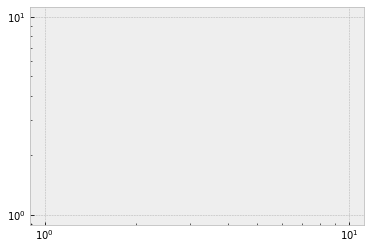

3162.2776601683795 
 100.0


In [59]:
#check for Fe I

plt.figure()
plt.plot(1.e7/nus,  op)
plt.yscale("log")
plt.xscale("log")
plt.show()
print(Tfix, '\n', Pfix)

# Compare with petitRADTRANS for METAL

written with reference to "[petitRadtran high-resolution IO.ipynb](https://gist.github.com/HajimeKawahara/69f633cfc29dffab913997a4b0e6a4c0)"

In [45]:
import pathlib
path_fig = pathlib.Path('/Users/chonmac/Dropbox/tmpfig') 

### Case of petitRADTRANS

In [46]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe/"

with open (petitdir+"wlen.dat") as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_pet="sigma_99_3250.K_0.100000bar.dat"
with open(petitdir+fn_pet, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)

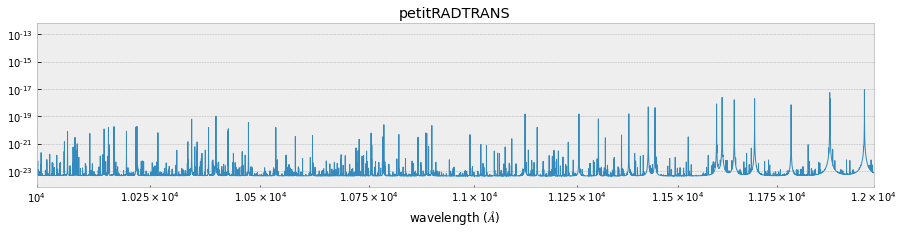

In [47]:
species_mass=55.847
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1)
plt.xlim(10000, 12000)

plt.yscale("log")
plt.xscale("log") 
plt.title('petitRADTRANS')
plt.xlabel("wavelength ($\AA$)")

plt.savefig(path_fig/'comp_petitR_Fe_210817test.pdf')

### Case of exojax

In [60]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

with open(petitdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_exo="sigma_99_3162.2776601683795.K_0.100000bar.dat"
with open(petitdir+fn_exo, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)

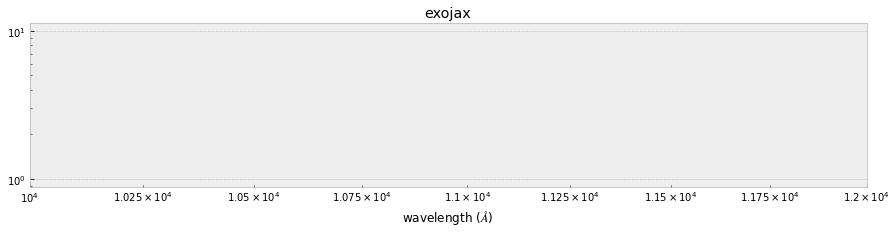

In [61]:
species_mass=55.847
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1)
plt.xlim(10000, 12000) 

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")

plt.savefig(path_fig/'comp_exojax_Fe_210817_gammatest.pdf')

In [63]:
contentf, contentw, contentf.shape, contentw.shape

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([0.0001  , 0.0001  , 0.0001  , ..., 0.000125, 0.000125, 0.000125]),
 (200000,),
 (200000,))

# Compare with petitRADTRANS for CO

copied from "[petitRadtran high-resolution IO.ipynb](https://gist.github.com/HajimeKawahara/69f633cfc29dffab913997a4b0e6a4c0)"  <font color="Fuchsia">for handy reference</font>    


### Case of petitRADTRANS

In [94]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/CO_all_iso/"
#petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe/"

with open (petitdir+"wlen.dat") as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_pet="sigma_05_900.K_0.100000bar.dat"
with open(petitdir+fn_pet, 'rb') as f:
    #with open(petitdir+"sigma_99_3250.K_0.100000bar.dat", 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)

<IPython.core.display.Javascript object>


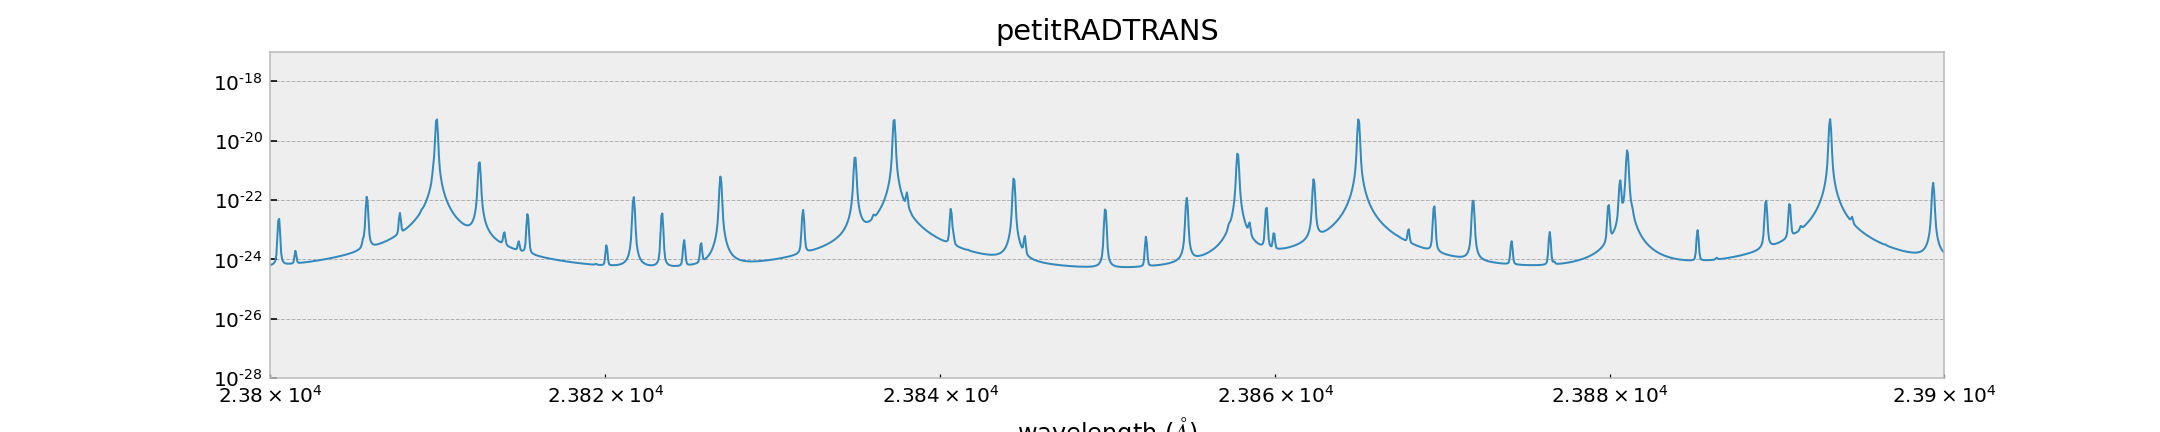

In [105]:
species_mass=28.01
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8,xs,lw=1)
plt.xlim(23800,23900)
plt.ylim(1e-28, 1e-17)

plt.yscale("log")
plt.xscale("log") 
plt.title('petitRADTRANS')
plt.xlabel("wavelength ($\AA$)")

plt.savefig(path_fig/'comp_petitR_CO_210817.pdf')

### Case of exojax

In [106]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/CO_exojax/"

with open(petitdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_exo="sigma_05_1000.0.K_0.100000bar.dat"
with open(petitdir+fn_exo, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)

<IPython.core.display.Javascript object>


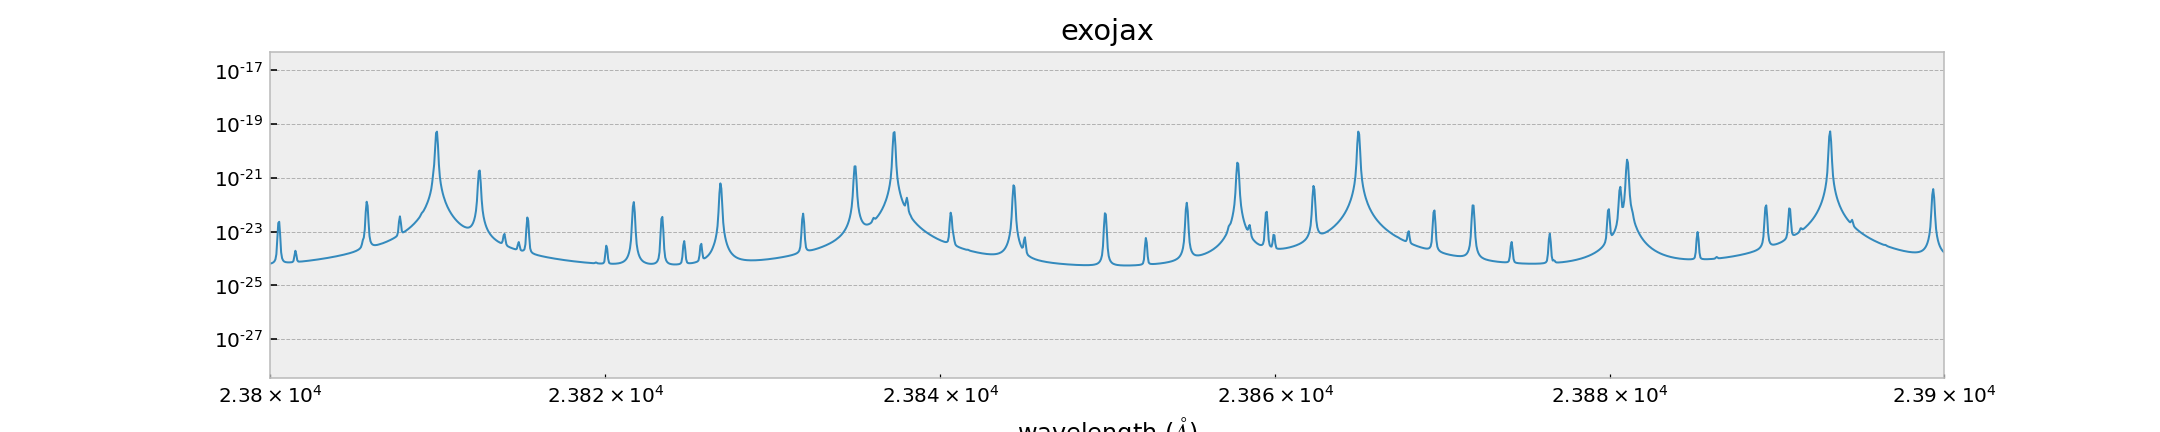

In [107]:
species_mass=28.01
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8,xs,lw=1)
plt.xlim(23800,23900)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")

plt.savefig(path_fig/'comp_exojax_CO_210817.pdf')